In [1]:
import sys,os
import pandas as pd 
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column, hstack, vstack
sys.path.append('../')
import surveySim
from copy import deepcopy
from scipy.interpolate import interp1d
import pickle

### Plan of attack
* fit log(SFR) vs z from SLACS sample
* estimate source redshifts for the DECALS sample
* use log(sfr) vs z fit to infer probable SFRs for DECALS sample
* compute CC and Ia explosion rates in N/rest-frame-yr for SLACS and DECALS
* apply efficiency corrections to get estimated detectable CC and Ia sample

In [2]:
def read_om_cat(filename,log):
    """Read in the OM10 catalog of lensed SN parameters"""
    wfirst = Table.read(filename,format='ascii')
    colnames=['NIMG','ZLENS','SIGMA','ZSRC','MAGH','APMAG_H','IMSEP','EPSILON','PHI','KAPPA','THETA',
             'XSRC','YSRC','TYP','LENSID']
    for i in range(len(wfirst.colnames)):
        wfirst.rename_column(wfirst.colnames[i],colnames[i])
    with open(log,'r') as f:
        log=f.readlines()
    ximg=[]
    yimg=[]
    mag=[]
    delay=[]
    i=0
    while i<len(log)-2:
        nimg=int(log[i][0])
        rows=log[i+1:i+nimg+1]
        i+=(nimg+1)
        dat=[]
        for row in rows:
            row=row.split(' ')
            row=[x.strip('\n') for x in row]
            row=[float(x) for x in row if len(x)>0]
            dat.append(row)
        ximg.append(np.array([x[0] for x in dat]))
        yimg.append(np.array([x[1] for x in dat]))
        mag.append(np.array([x[2] for x in dat]))
        delay.append(np.array([x[3] for x in dat]))

    wfirst['XIMG']=ximg
    wfirst['YIMG']=yimg
    wfirst['MAG']=mag
    wfirst['DELAY']=delay
    wfirst['MAG']=np.array([-2.5*np.log10(np.abs(x)) for x in wfirst['MAG']])
    return(wfirst)

### Define a fiducial zsrc/zlens ratio based on the OM10 catalog

In [3]:
lsst=read_om_cat('sne_mock_result.dat','sne_mock_log.dat')
lsst['MAG']=10**(-.4*np.array([np.max(x[x!=1]) for x in lsst['MAG']]))
fiducial_lens_zratio=np.median(lsst['ZSRC']/lsst['ZLENS'])

In [4]:
def lin_reg(x,y,yerr):
    
    A=np.array([[1,x] for x in x])
    Y=np.array(y)
    C=np.zeros((len(x),len(x)),int)
    np.fill_diagonal(C,1)
    C=np.multiply(C,yerr**2)

    X_VAR=np.linalg.inv(np.matmul(A.T,np.matmul(np.linalg.pinv(C),A)))
    X=np.matmul(X_VAR,
                np.matmul(A.T,np.matmul(np.linalg.pinv(C),Y)))
    X_SIGMA=np.sqrt([X_VAR[0,0],X_VAR[1,1]])
    return([(X[i],X_SIGMA[i]) for i in range(len(X))])

In [5]:
def error_on_log10x(x, xerr):
    """ returns the error on log10(x), given x and xerr"""
    return( (xerr / x) * np.log10(np.e) )

def error_from_log10x(log10x, log10x_err):
    """ returns the error on x, given log10(x) and log10(x)_err"""
    return( 10**log10x * log10x_err / np.log10(np.e))

### Fit log(sfr) vs z from SLACS

* Note: correcting the SFR for the (1+z)^2 error that Yiping identified!!

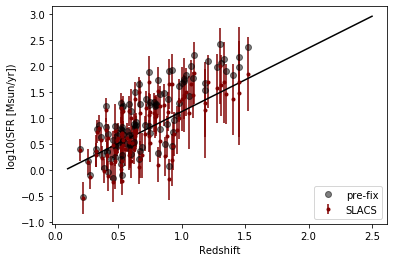

In [11]:
slacs = ascii.read('../surveySim/data/examples/galaxies.dat')
zsrc_slacs = slacs['Z']
sfr_slacs_prefix = slacs['SFR']
sfr_slacs = slacs['SFR'] / (1+zsrc_slacs**2)   # Here is that (1+z)^2 correction
sfrerr_slacs = slacs['SFR_err']

logsfr_slacs_prefix = np.log10(sfr_slacs_prefix)

logsfr_slacs = np.log10(sfr_slacs)
logsfrerr_slacs = error_on_log10x( sfr_slacs, sfrerr_slacs) 

plt.plot(zsrc_slacs,logsfr_slacs_prefix,
         marker='o', ls=' ', color='k', label='pre-fix', alpha=0.5)

plt.errorbar(zsrc_slacs,logsfr_slacs,logsfrerr_slacs,
             fmt='.', color='maroon', label='SLACS')

# Linear fit to log(SFR) vs z data
logsfr_b,logsfr_m = lin_reg(zsrc_slacs,logsfr_slacs,logsfrerr_slacs)
zrange = np.arange(.1,2.6,.1)
plt.plot(zrange,zrange*logsfr_m[0]+logsfr_b[0], 
         color='k', ls='-', marker=' ')
ax = plt.gca()
plt.xlabel('Redshift')
plt.ylabel('log10(SFR [Msun/yr])')
#plt.text(0.05,0.95, 'SLACS', transform=ax.transAxes, ha='left', va='top', color='maroon')
ax.legend(loc='lower right')
plt.savefig('logsfr_vs_z_slacs.png',format='png')

### Define functions that give the ratio of number of SN Ia to number of core collapse SNe as a function of z

Where are these from?

In [12]:
def _getTheta1(z):
    """
    (Private)
    Heler function for SNR_Ia/SNR_CC.

    """
    func=interp1d([0,.25,.5,.75,1,1.25],[.25,.17,.16,.155,.15,.15], 
                  bounds_error=False, fill_value='extrapolate')
    return(func(z)/(1-func(z)))

def _getTheta2(z):
    """
    (Private)
    Heler function for SNR_Ia/SNR_CC.

    """
    func=interp1d([1.25,1.7],[.15,.08],  bounds_error=False, fill_value=float(.05/(1-.05)))
    return(func(z)/(1-func(z)))

def ratio_of_Ia_to_CC(zarray):
    """Define the ratio N_Ia/N_cc explosions for an array of z values"""
    thetas = np.where(zarray<=1.25, _getTheta1(zarray), _getTheta2(zarray))
    return(thetas)
                      

Text(0, 0.5, 'Ratio of N_Ia to N_CC explosions')

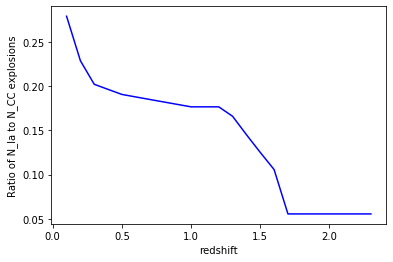

In [13]:
zrange = np.arange(0.1, 2.4, 0.1)
niancc = ratio_of_Ia_to_CC(zrange)
plt.plot(zrange, niancc, color='b', ls='-')
ax = plt.gca()
ax.set_xlabel("redshift")
ax.set_ylabel('Ratio of N_Ia to N_CC explosions')

### Estimate source redshift and SFR for DECaLS lens sample 

In [14]:
decals=Table(names=['Target','type','mag_g','mag_r','mag_z','prob','zlens', 'survey'],
             dtype=['S40','S4',np.float32,np.float32,np.float32,np.float32,np.float32,'S4'])
with open('huang_2019.dat','r') as f:
    dat=f.readlines()
for line in dat:
    if 'Target' in line:
        continue
    line=line.split()
    if len(line)<len(decals.colnames):
        continue
    row={}
    for i in range(len(decals.colnames)):
        row[decals.colnames[i]]=line[i]
    decals.add_row(row)        

zsrc_decals = decals['zlens']*fiducial_lens_zratio

zsrc_column = Column(zsrc_decals, name='zsrc')
niancc_column = Column(ratio_of_Ia_to_CC(zsrc_decals), name='NIa/Ncc')
logsfr_decals = zsrc_decals*logsfr_m[0]+logsfr_b[0]
logsfr_column = Column(logsfr_decals, name='log10(SFR)')

# estimate the SFR error as the scatter about the mean
logsfr_slacs_fit = zsrc_slacs * logsfr_m[0] + logsfr_b[0]
logsfr_stdev = np.std( logsfr_slacs - logsfr_slacs_fit )
logsfrerr_decals = logsfr_stdev * np.ones(len(logsfr_decals))
logsfrerr_column = Column(logsfrerr_decals, name='log10(SFR)_err')

# Convert log(sfr) and log(sfr)_err into SFR and SFR_err:
sfr_decals = 10**(logsfr_decals)
sfrerr_decals = error_from_log10x(logsfr_decals, logsfrerr_decals)
sfr_column = Column(sfr_decals, name='SFR')
sfrerr_column = Column(sfrerr_decals, name='SFR_err')

decals.add_columns([zsrc_column, niancc_column, 
                    logsfr_column, logsfrerr_column,
                    sfr_column, sfrerr_column])

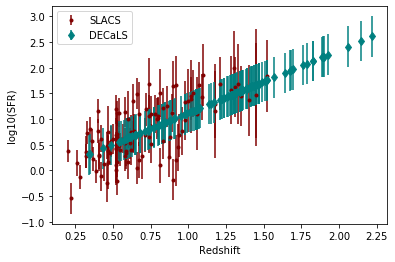

In [15]:

# Re-plot the SLACS sample
plt.errorbar(zsrc_slacs,logsfr_slacs,logsfrerr_slacs,
             fmt='.', color='maroon', label='SLACS')

# Add the inferred properties of the DECALS sample
plt.errorbar(decals['zsrc'], decals['log10(SFR)'], decals['log10(SFR)_err'], 
             marker='d', color='teal', ls=' ', label='DECaLS')

plt.xlabel('Redshift')
plt.ylabel('log10(SFR)')

ax = plt.gca()
ax.legend()
plt.savefig('logsfr_vs_z_slacs_decals.png',format='png')

### Imagining an LSST-HST survey, with single-epoch depth i=24.0 

In [16]:
# Compute the number of SN exploding per obs-frame-year in the 
# SLACS and DECALS galaxies

def NSN_exploding_per_obsframe_year(sfr, sfr_err, zsrc, kcc=7.5e-3):
    """compute the number of SN explosions per 
    observer-frame year.
    
    INPUTS:
    sfr : the star formation rate in each galaxy
    z : the redshift of each galaxy
    kcc : the formation efficiency of CC SNe (#CCSN / Msun formed)
    
    RETURNS:
    Nexp dict containing:
    Ntotexp, Ntotexp_err : total number of explosions per obs-frame yr and uncertainty
    NIaexp, NIaexp_err : number of Ia explosions per obs-frame yr and uncertainty
    NCCexp, NCCexp_err : number of CC explosions per obs-frame yr and uncertainty
    """
    if not np.iterable(sfr):
        sfr = np.array([sfr])
    if not np.iterable(zsrc):
        zsrc = np.array([zsrc])
    
    # The number of CC SN explosions is directly prop. to the SFR
    # and the factor of (1+z) corrects from the rest frame to the observer-frame time
    NCCexp = kcc  * sfr / (1+zsrc)
    NCCexp_err = NCCexp * (sfr_err / sfr)

    # The ratio of SNIa to CCSN evolves with z.
    niancc = ratio_of_Ia_to_CC(zsrc)
    
    # what is the factor of 1.035 for??
    NIaexp = 1.035 * niancc * NCCexp
    NIaexp_err = NIaexp * NCCexp_err/NCCexp
    
    Ntotexp = NIaexp + NCCexp
    Ntotexp_err = np.sqrt(NIaexp_err**2 + NCCexp_err**2)
    return( Table({"Ntotexp":Ntotexp, "Ntotexp_err":Ntotexp_err, 
                   "NIaexp":NIaexp, "NIaexp_err":NIaexp_err, 
                   "NCCexp":NCCexp, "NCCexp_err":NCCexp_err}))

In [17]:

# compute the number of explosions in each DECaLS and SLACS source galaxy, per obs-frame yr
Nexp_slacs = NSN_exploding_per_obsframe_year(sfr_slacs, sfrerr_slacs, zsrc_slacs)

Nexp_decals = NSN_exploding_per_obsframe_year(sfr_decals, sfrerr_decals, zsrc_decals)


print("Total # of SN explosions per obs-frame-yr in SLACS: {:.1f}".format(Nexp_slacs["Ntotexp"].sum()))

print("Total # of SN explosions per obs-frame-yr in DECaLS: {:.1f}".format(Nexp_decals["Ntotexp"].sum()))


Total # of SN explosions per obs-frame-yr in SLACS: 6.6
Total # of SN explosions per obs-frame-yr in DECaLS: 15.8


### Quick sanity check: do we agree with Yiping?

Yiping Shu made predicted SN explosion rates for all the SLACS sources, and they are included in the table we have.  The figure below compares our new estimates to his estimates.

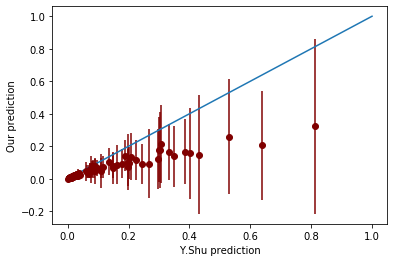

In [18]:
plt.errorbar(slacs['N_CC'], Nexp_slacs['NCCexp'], Nexp_slacs['NCCexp_err'], marker='o', ls=' ', color='maroon', label='SLACS')
ax = plt.gca()
ax.set_xlabel("Y.Shu prediction")
ax.set_ylabel("Our prediction")
plt.plot([0,1], [0,1], marker=' ', ls='-')

### Update the SLACS and DECALS tables to include our predicted yields
and combine into a single vstack table

In [19]:
# re-read the SLACS data (in case we're re-running this cell midstream)
slacs = ascii.read('../surveySim/data/examples/galaxies.dat')
slacs.add_column(Column(data=['SLACS' for i in range(len(slacs))], name='sample'))
slacs.rename_column("ZL", 'zlens')
slacs.rename_column("Z", 'zsrc')

# Add columns with the expected number of SN explosions per obs-frame year
slacs = hstack([slacs, Nexp_slacs], join_type='exact')

# remove unwanted columns
for colname in np.unique(slacs.colnames+decals.colnames):
    if colname not in ['Target', 'zlens', 'zsrc', 'mu', 'SFR', 'SFR_err',
                       'Ntotexp','Ntotexp_err','NIaexp','NIaexp_err','NCCexp','NCCexp_err',
                       'sample']:
        if colname in slacs.colnames:
            slacs.remove_column(colname)
        if colname in decals.colnames:
            decals.remove_column(colname)
    
# make a composite of decals+slacs, starting with decals:
decals_mod = deepcopy(decals)

# Add columns with the expected number of SN explosions per obs-frame year
decals_mod = hstack([decals, Nexp_decals], join_type='exact')

# add magnification to decals
decals_mod.add_column(Column(data=np.ones(len(decals))*10.0, name='mu'))
decals_mod.add_column(Column(data=['DECaLS' for i in range(len(decals))], name='sample'))

all_targets = vstack([slacs, decals_mod], join_type='exact')



In [20]:
all_targets[:3]

Target,zlens,zsrc,mu,SFR,SFR_err,sample,Ntotexp,Ntotexp_err,NIaexp,NIaexp_err,NCCexp,NCCexp_err
str40,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64
SLACSJ,0.23,0.93,23.0,5.3,3.0,SLACS,0.013083275847683132,0.011855121704265675,0.0020393298332696034,0.00215272426758367,0.011043946014413528,0.011658031088082901
SLACSJ,0.2,0.63,6.0,6.3,3.2,SLACS,0.024763578225898076,0.014996596827354226,0.004012107067368696,0.0028467364380481684,0.02075147115852938,0.0147239263803681
SLACSJ,0.12,0.2,2.0,2.5,1.2,SLACS,0.018577205100642598,0.0077068901884465735,0.0035531666391041385,0.0017737407862407858,0.01502403846153846,0.007499999999999999


In [21]:
all_targets.write("../surveySim/data/examples/slacs+decals_galaxies.csv", 
                  format='csv', formats=dict([(colname,'%.3f') for colname in all_targets.colnames 
                                              if colname.startswith('N')]))

### Now lets see how many we could detect

In [22]:
# First read in the all_targets catalog of galaxy properties 
targeted_galaxies_table = Table.read("../surveySim/data/examples/slacs+decals_galaxies.csv")


In [23]:
targeted_galaxies_table[:3]

Target,zlens,zsrc,mu,SFR,SFR_err,sample,Ntotexp,Ntotexp_err,NIaexp,NIaexp_err,NCCexp,NCCexp_err
str21,float64,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64
SLACSJ,0.23,0.93,23.0,5.3,3.0,SLACS,0.013,0.012,0.002,0.002,0.011,0.012
SLACSJ,0.2,0.63,6.0,6.3,3.2,SLACS,0.025,0.015,0.004,0.003,0.021,0.015
SLACSJ,0.12,0.2,2.0,2.5,1.2,SLACS,0.019,0.008,0.004,0.002,0.015,0.007


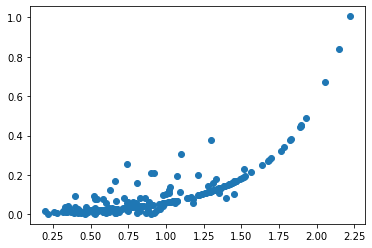

In [24]:
plt.plot(targeted_galaxies_table['zsrc'], targeted_galaxies_table['Ntotexp'], marker='o', ls=' ')

In [37]:
len(targeted_galaxies_table)

230

In [32]:
def run_lsst_hst_surveysims(z1=0, z2=1.0, bands=['lsstr','lssti','lsstz'], suffix=''):
    """ Sets up and runs an LSST-HST survey sim, then stores the resulting yields as a pickle"""

    surveyname = 'LSST-HST' + suffix
    print("%s : %.1f < z < %.1f [%s]"%(surveyname, z1, z2, ','.join(bands)))

    zsrc = targeted_galaxies_table['zsrc'].data
    izlim = np.where((zsrc>=z1) & (zsrc<=z2))[0]

    lsst_hst_galaxies = targeted_galaxies_table[izlim]
    
    lsst_hst = surveySim.survey(name=surveyname,snTypes=["Ia",'Ib','Ic','IIP','IIn','IIb','IIL'])
    lsst_hst.mu=10  # baseline assumption: fixed magnification for every lens. 
    lsst_hst.cadence = 3 * u.day  # see fig 2.8 from https://arxiv.org/pdf/1708.04058.pdf
    lsst_hst.surveyLength = (5./12) * u.year # assumed visibility of 5 months/yr for each target
    lsst_hst.verbose=True

    lsst_hst.filters=bands
    magLimits = {'lsstr':24.16,'lssti':23.4, 'lsstz':22.23}
    lsst_hst.magLimits= [magLimits[band] for band in lsst_hst.filters]
    
    lsst_hst.galaxies = lsst_hst_galaxies
    lsst_hst.targetedSurvey( zpsys='ab', Ia_av=.3286, CC_av=.3286, lc_sampling=10, before_peak=False)

    for band in lsst_hst.filters:
        total = lsst_hst.total_yield[band]
        print('Yield for band %s:%.2f'%(band, lsst_hst.total_yield[band]))

    poiss=lsst_hst.calc_poiss()
    for b in poiss.keys():
        print('Probability of observing at least 1 SN in band %s:%.2f'%(b,poiss[b]))

    picklefile = '../surveySim/data/examples/%s_yields.pkl'%surveyname
    pickle.dump(lsst_hst.yields, open(picklefile,'wb'))
    print("Pickled yields to "+picklefile)
    return(lsst_hst)

In [33]:
lsst_hst_lowz = run_lsst_hst_surveysims(z1=0, z2=1.0, bands=['lsstr', 'lssti', 'lsstz'], suffix='_lowz')

LSST-HST_lowz : 0.0 < z < 1.0 [lsstr,lssti,lsstz]
Did not find galaxy mass column, change name to "mass" if it exists, otherwise using scale factor.
Yield for band lsstr:2.12
Yield for band lssti:1.74
Yield for band lsstz:1.09
Probability of observing at least 1 SN in band lsstr:0.88
Probability of observing at least 1 SN in band lssti:0.82
Probability of observing at least 1 SN in band lsstz:0.66
Pickled yields to ../surveySim/data/examples/LSST-HST_lowz_yields.pkl


In [34]:
lsst_hst_midz = run_lsst_hst_surveysims(z1=1.0, z2=1.8, bands=['lssti', 'lsstz'], suffix='_midz')

LSST-HST_midz : 1.0 < z < 1.8 [lssti,lsstz]
Did not find galaxy mass column, change name to "mass" if it exists, otherwise using scale factor.
Yield for band lssti:1.30
Yield for band lsstz:0.51
Probability of observing at least 1 SN in band lssti:0.73
Probability of observing at least 1 SN in band lsstz:0.40
Pickled yields to ../surveySim/data/examples/LSST-HST_midz_yields.pkl


In [35]:
lsst_hst_higherz = run_lsst_hst_surveysims(z1=1.8, z2=2.3, bands=['lsstz'], suffix='_higherz')

LSST-HST_higherz : 1.8 < z < 2.3 [lsstz]
Did not find galaxy mass column, change name to "mass" if it exists, otherwise using scale factor.
Yield for band lsstz:0.03
Probability of observing at least 1 SN in band lsstz:0.03
Pickled yields to ../surveySim/data/examples/LSST-HST_higherz_yields.pkl


In [36]:
print(lsst_hst_lowz)

Survey Name: LSST-HST_lowz
     Length: 0.4166666666666667 Years
     Cadence: 3.0 Days
     Number of Galaxies: 134
     Redshift Range: 0.2-->1.0
-------------------
Filter=lsstr, Limiting Magnitude=24.16(ab)

     Upper Bound Ia:0.62
     Lower Bound Ia:0.31
     Upper Bound Ib:0.16
     Lower Bound Ib:0.08
     Upper Bound Ic:0.43
     Lower Bound Ic:0.22
     Upper Bound IIP:0.89
     Lower Bound IIP:0.44
     Upper Bound IIn:0.36
     Lower Bound IIn:0.18
     Upper Bound IIb:0.08
     Lower Bound IIb:0.04
     Upper Bound IIL:0.29
     Lower Bound IIL:0.15

     Total Ia Upper Bound:0.62
     Total Ia Lower Bound:0.31
     Total CC Upper Bound:2.2
     Total CC Lower Bound:1.1

     Total Lower Bound:1.41
     Total Expectation:2.12
     Total Upper Bound:2.82
-------------------
-------------------
Filter=lssti, Limiting Magnitude=24.16(ab)

     Upper Bound Ia:0.63
     Lower Bound Ia:0.31
     Upper Bound Ib:0.17
     Lower Bound Ib:0.08
     Upper Bound Ic:0.45
     Lower Bo

### See the lsst_hst_surveysim_plots notebook for plotting results